In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt
from random import seed
import numpy as np

In [3]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [4]:
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
# plt.imshow(transforms.ToPILImage()(X_train[0][0]))

In [5]:
X_train = FashionMNIST(download=True,
                  root="./data/",
                  train=True,
                  transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()]))


X_test = FashionMNIST(download=True,
                  root="./data/",
                  train=False,
                  transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()]))

from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 50000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
n_val_samples = 10000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
n_test_samples = 10000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import time

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


class SomeCNN(torch.nn.Module):
    def __init__(self):
        super(SomeCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=18,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1) # kernel=3, padding=1 -> size is the same
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # kernel=2 stride = 2 -> size  /= 2 
        
        self.conv2 = torch.nn.Conv2d(in_channels=18,
                                     out_channels=18,
                                     kernel_size=2,
                                     stride=2,
                                     padding=0) # kernel=2, stride=2 -> size /= 2
        
        self.fc1 = torch.nn.Linear(18 * 7 * 7, 64)
        
        self.fc2 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        #(1, 28, 28)
        x = F.relu(self.conv1(x))
        #(1, 28, 28)
        x = self.pool(x)
        #(18, 14, 14)
        x = F.relu(self.conv2(x))        
        #Reshape (18, 7, 7) -> (1, 18*7*7)
        x = x.view(-1, 18 * 7 *7)
        #(1, 18*7*7)
        x = F.relu(self.fc1(x))
        #(1, 32)
        x = self.fc2(x)
        # (1, 10)
        return(x)

In [7]:
import torch.optim as optim
def createLossAndOptimizer(net, learning_rate=0.001):
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return(loss, optimizer)

In [43]:
batch_size = 15
n_epochs = 5
learning_rate = 0.01

print("===== HYPERPARAMETERS =====")
print("batch_size=", batch_size)
print("epochs=", n_epochs)
print("learning_rate=", learning_rate)
print("=" * 30)


trainloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=2)
valloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size,
                                          sampler=val_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(X_test, batch_size=batch_size,
                                          sampler=test_sampler, num_workers=2)


model = SomeCNN()
n_batches = len(trainloader)
loss, optimizer = createLossAndOptimizer(model, learning_rate)

training_start_time = time.time()
losses = []

for epoch in range(n_epochs):

    running_loss = 0.0
    print_every = n_batches // 10
    start_time = time.time()
    total_train_loss = 0
    
    for i, batch in enumerate(trainloader, 0):
        inputs, labels = batch
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

        optimizer.zero_grad()

        #Forward pass, backward pass, optimize
        outputs = model(inputs)
        loss_size = loss(outputs, labels)
        loss_size.backward()
        optimizer.step()

        #Print statistics
        running_loss += loss_size.data[0]
        total_train_loss += loss_size.data[0]

        #Print every 10th batch of an epoch
        if (i + 1) % (print_every + 1) == 0:
            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
            #Reset running loss and time
            losses.append(running_loss / print_every)
            running_loss = 0.0
            start_time = time.time()

    #At the end of the epoch, do a pass on the validation set
    total_val_loss = 0
    for inputs, labels in testloader:

        #Wrap tensors in Variables
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

        #Forward pass
        val_outputs = model(inputs)
        val_loss_size = loss(val_outputs, labels)
        total_val_loss += val_loss_size.data[0]

    print("Validation loss = {:.2f}".format(total_val_loss / len(valloader)))

print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

===== HYPERPARAMETERS =====
batch_size= 15
epochs= 5
learning_rate= 0.01


/home/vbv/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/vbv/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 0.95 took: 3.04s
Epoch 1, 20% 	 train_loss: 0.57 took: 2.92s
Epoch 1, 30% 	 train_loss: 0.51 took: 5.33s
Epoch 1, 40% 	 train_loss: 0.47 took: 4.90s
Epoch 1, 50% 	 train_loss: 0.47 took: 6.34s
Epoch 1, 60% 	 train_loss: 0.45 took: 6.01s
Epoch 1, 70% 	 train_loss: 0.45 took: 6.38s
Epoch 1, 80% 	 train_loss: 0.47 took: 5.60s
Epoch 1, 90% 	 train_loss: 0.43 took: 3.62s


/home/vbv/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 0.45
Epoch 2, 10% 	 train_loss: 0.41 took: 3.70s
Epoch 2, 20% 	 train_loss: 0.41 took: 3.94s
Epoch 2, 30% 	 train_loss: 0.42 took: 4.01s
Epoch 2, 40% 	 train_loss: 0.45 took: 3.95s
Epoch 2, 50% 	 train_loss: 0.40 took: 3.85s
Epoch 2, 60% 	 train_loss: 0.43 took: 3.90s
Epoch 2, 70% 	 train_loss: 0.41 took: 3.91s
Epoch 2, 80% 	 train_loss: 0.43 took: 3.89s
Epoch 2, 90% 	 train_loss: 0.41 took: 3.96s
Validation loss = 0.40
Epoch 3, 10% 	 train_loss: 0.42 took: 3.96s
Epoch 3, 20% 	 train_loss: 0.39 took: 3.85s
Epoch 3, 30% 	 train_loss: 0.40 took: 3.91s
Epoch 3, 40% 	 train_loss: 0.40 took: 4.03s
Epoch 3, 50% 	 train_loss: 0.40 took: 3.88s
Epoch 3, 60% 	 train_loss: 0.41 took: 3.84s
Epoch 3, 70% 	 train_loss: 0.39 took: 3.90s
Epoch 3, 80% 	 train_loss: 0.41 took: 3.82s
Epoch 3, 90% 	 train_loss: 0.39 took: 4.02s
Validation loss = 0.43
Epoch 4, 10% 	 train_loss: 0.38 took: 3.59s
Epoch 4, 20% 	 train_loss: 0.38 took: 3.44s
Epoch 4, 30% 	 train_loss: 0.39 took: 3.46s
Epoch 4

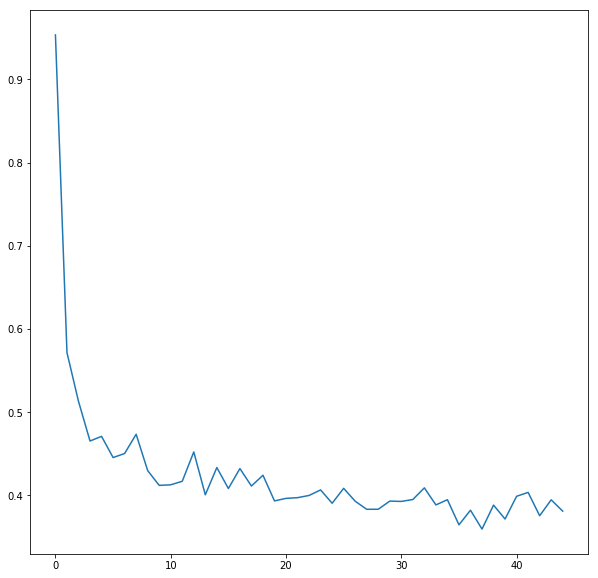

In [50]:
plt.plot(range(n_epochs * n_batches // print_every - n_epochs), losses)

In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy on the 10000 test images: 84 %


In [10]:
from sklearn.decomposition import PCA 

In [15]:
X_train_list = [x[0].numpy() for x in X_train]
y_train_list = [x[1].numpy() for x in X_train]

In [31]:
X_train_list = [x.reshape((28*28,)) for x in X_train_list]
y_train_list = [x+1-1 for x in y_train_list]

In [34]:
reductor = PCA(n_components=2)
X_train_pcaed = reductor.fit_transform(X_train_list)

In [38]:
plt.rcParams['figure.figsize'] = (10, 10)

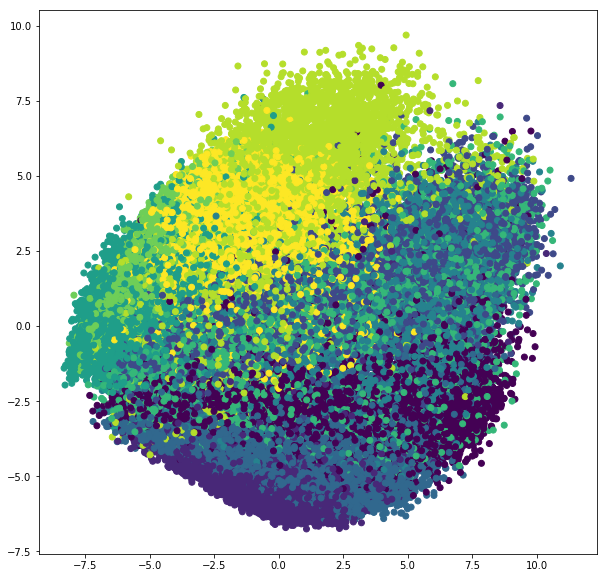

In [39]:
plt.scatter(X_train_pcaed[:,0], X_train_pcaed[:,1], c=y_train_list)
plt.show()